In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
import matplotlib.pyplot as plt

In [59]:
# File path for the preprocessed data
file_path = 'hemodat_preprocessed.csv'

In [60]:
# Load the preprocessed data
data_preprocessed = pd.read_csv(file_path)

In [61]:
# Filter valid blood donors (without medical conditions)
valid_donors = data_preprocessed[data_preprocessed['Category'] == '0=Blood Donor']


In [62]:
# Prepare data for anomaly detection
features = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
X_valid = valid_donors[features]
X_valid = (X_valid - X_valid.mean()) / X_valid.std()  # Standardize the data


In [63]:
# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_valid)

IsolationForest(contamination=0.05, random_state=42)

In [64]:
# Predict anomalies for all donors
X_all = data_preprocessed[features]
X_all = (X_all - X_all.mean()) / X_all.std()  # Standardize the data
predictions = iso_forest.predict(X_all)
data_preprocessed['Anomaly'] = predictions  # -1 for anomaly, 1 for normal


In [65]:
# Evaluate accuracy on donors with medical conditions
actual_labels = (data_preprocessed['Category'] != '0=Blood Donor').astype(int)  # 1 for medical condition, 0 otherwise
predicted_labels = (data_preprocessed['Anomaly'] == -1).astype(int)  # 1 for anomaly, 0 otherwise

In [66]:
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       533
           1       0.93      0.45      0.61        82

    accuracy                           0.92       615
   macro avg       0.92      0.72      0.78       615
weighted avg       0.92      0.92      0.91       615



In [67]:
print("\nConfusion Matrix:")
print(confusion_matrix(actual_labels, predicted_labels))


Confusion Matrix:
[[530   3]
 [ 45  37]]


High True Negatives (530): The model is very good at identifying class 0 (negative cases).
Relatively Low True Positives (37): The model struggles to correctly identify class 1 (positive cases).
False Negatives (45): A significant number of positive cases are misclassified as negative.
False Positives (3): Very few negative cases are misclassified as positive.

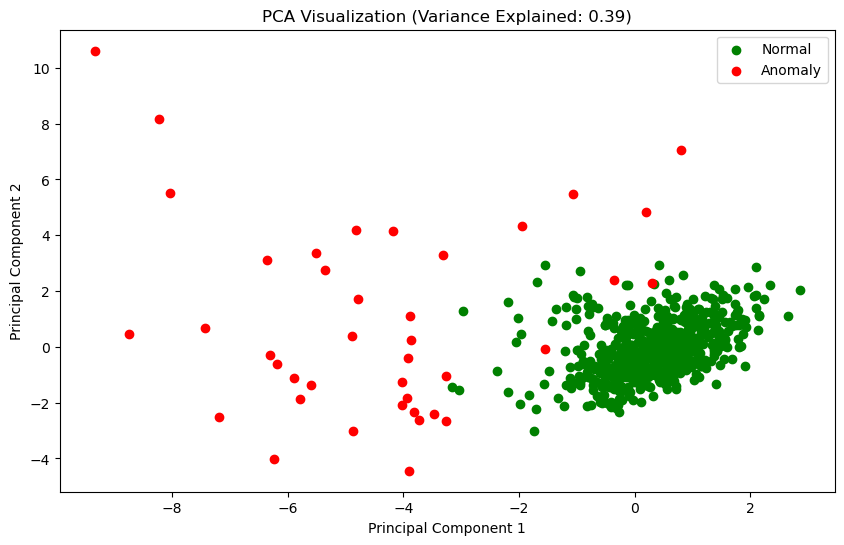

In [68]:
#PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)
variance_explained = pca.explained_variance_ratio_.sum()
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[predictions == 1, 0], X_pca[predictions == 1, 1], c='green', label='Normal')
plt.scatter(X_pca[predictions == -1, 0], X_pca[predictions == -1, 1], c='red', label='Anomaly')
plt.title(f"PCA Visualization (Variance Explained: {variance_explained:.2f})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

Clusters of Green Points: These represent the majority of the data that the model considers "normal."
Red Outliers: Points scattered away from the main clusters, flagged as anomalies.

In [69]:
# Save the preprocessed data with anomaly predictions
output_path = 'hemodat_with_anomalies.csv'
data_preprocessed.to_csv(output_path, index=False)

In [70]:
print(f"Dataset with anomalies saved to {output_path}")

Dataset with anomalies saved to hemodat_with_anomalies.csv


In [71]:
# Prepare data for decision tree classification
features = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
X = data_preprocessed[features]
y = (data_preprocessed['Category'] != '0=Blood Donor').astype(int)  # 1 for medical condition, 0 for blood donor

In [72]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [73]:
# Train a Decision Tree Classifier
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)  # Max depth for simplicity
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [74]:
# Evaluate the model
y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        96
           1       1.00      0.52      0.68        27

    accuracy                           0.89       123
   macro avg       0.94      0.76      0.81       123
weighted avg       0.91      0.89      0.88       123



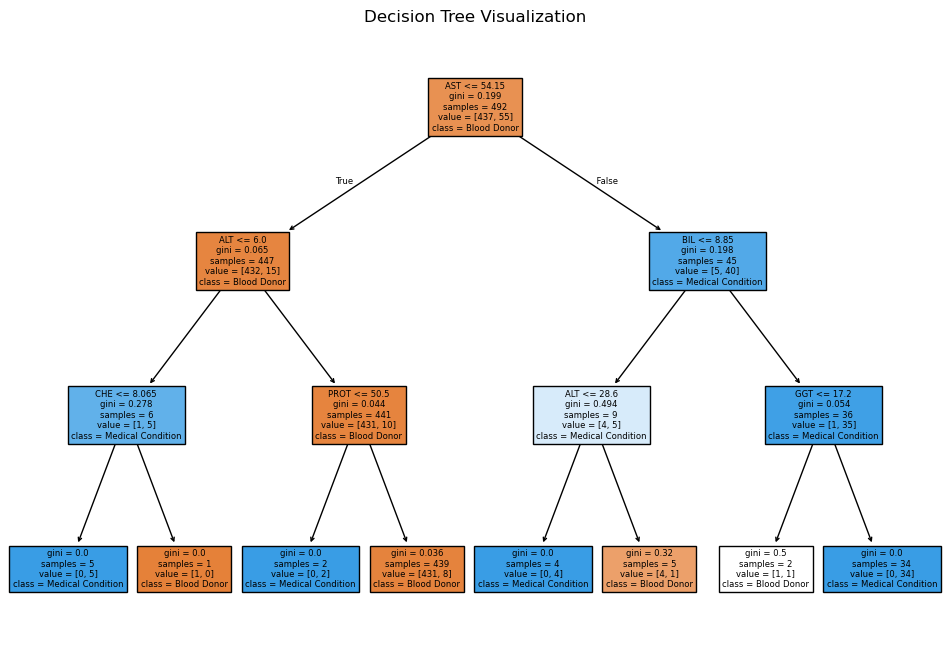

In [75]:
# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, feature_names=features, class_names=['Blood Donor', 'Medical Condition'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

Root Node (Topmost Box):
   - The tree starts with a **root node** at the top. It uses the feature `ALT <= 6.0` to split the data into two groups: True (left branch) and False (right branch).
Splits (Decision Points):
   - Each box (node) in the tree represents a decision based on a feature value.
   - For example, at the root, the tree checks whether `ALT` (a feature) is less than or equal to 6.0 to decide which path to take.
Values Inside Nodes:
   - Gini: A measure of how "pure" the split is (lower values mean better splits).
   - Samples: The number of data points in that node.
   - Value: The number of samples for each class (e.g., `[432, 15]` means 432 are class "Blood Donor" and 15 are class "Medical Condition").
   - Class: The majority class in that node.
Leaf Nodes (Bottom Boxes):
   - The tree ends with leaf nodes, where no further splitting is possible.
   - Each leaf node predicts a class (e.g., "Blood Donor" or "Medical Condition").
Path Through the Tree:
   - Data points start at the root and follow the branches based on feature values until they reach a leaf node, which gives the final prediction.

In [76]:
# Display the decision rules
print("\nDecision Tree Rules:")
print(export_text(decision_tree, feature_names=features))


Decision Tree Rules:
|--- AST <= 54.15
|   |--- ALT <= 6.00
|   |   |--- CHE <= 8.07
|   |   |   |--- class: 1
|   |   |--- CHE >  8.07
|   |   |   |--- class: 0
|   |--- ALT >  6.00
|   |   |--- PROT <= 50.50
|   |   |   |--- class: 1
|   |   |--- PROT >  50.50
|   |   |   |--- class: 0
|--- AST >  54.15
|   |--- BIL <= 8.85
|   |   |--- ALT <= 28.60
|   |   |   |--- class: 1
|   |   |--- ALT >  28.60
|   |   |   |--- class: 0
|   |--- BIL >  8.85
|   |   |--- GGT <= 17.20
|   |   |   |--- class: 0
|   |   |--- GGT >  17.20
|   |   |   |--- class: 1



In [77]:
# Trace the decision path for each test sample
def trace_decision_path(model, sample, feature_names):
    node_indicator = model.decision_path([sample])
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    decision_path = []
    for node_id in node_indicator.indices:
        if feature[node_id] != -2:  # Not a leaf node
            feature_name = feature_names[feature[node_id]]
            threshold_value = threshold[node_id]
            comparison = "<=" if sample[feature[node_id]] <= threshold_value else ">"
            decision_path.append(f"{feature_name} {comparison} {threshold_value:.2f}")

    return " -> ".join(decision_path)

In [78]:
# Print decision paths for a few test samples
for i in range(5):  # Limit to 5 samples for clarity
    sample = X_test.iloc[i]
    path = trace_decision_path(decision_tree, sample.values, features)
    print(f"Sample {i+1} Decision Path: {path}")

Sample 1 Decision Path: AST <= 54.15 -> ALT > 6.00 -> PROT > 50.50
Sample 2 Decision Path: AST <= 54.15 -> ALT > 6.00 -> PROT > 50.50
Sample 3 Decision Path: AST <= 54.15 -> ALT > 6.00 -> PROT > 50.50
Sample 4 Decision Path: AST > 54.15 -> BIL > 8.85 -> GGT > 17.20
Sample 5 Decision Path: AST <= 54.15 -> ALT > 6.00 -> PROT > 50.50


C:\Users\khush\Downloads\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\khush\Downloads\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\khush\Downloads\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\khush\Downloads\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\khush\Downloads\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


The decision path helps understand how the model reaches a conclusion by outlining the checks it performs step by step based on the feature values. The sample output is simply showing how the tree processes each test sample to classify it.

In [79]:
# Train and optimize XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\khush\Downloads\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\khush\Downloads\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\khush\Downloads\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\khush\D

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

The code trains an XGBoost classifier and tunes its hyperparameters (like tree depth, learning rate, and number of trees) using grid search. The goal is to find the best combination of these parameters to maximize accuracy, and it does this by evaluating each combination using 3-fold cross-validation.

In [80]:
# Best model from grid search
best_xgb_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [81]:
# Evaluate the XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        96
           1       1.00      0.81      0.90        27

    accuracy                           0.96       123
   macro avg       0.98      0.91      0.94       123
weighted avg       0.96      0.96      0.96       123




Local Explanations for 5 Selected Samples:
Sample 1 Explanation:


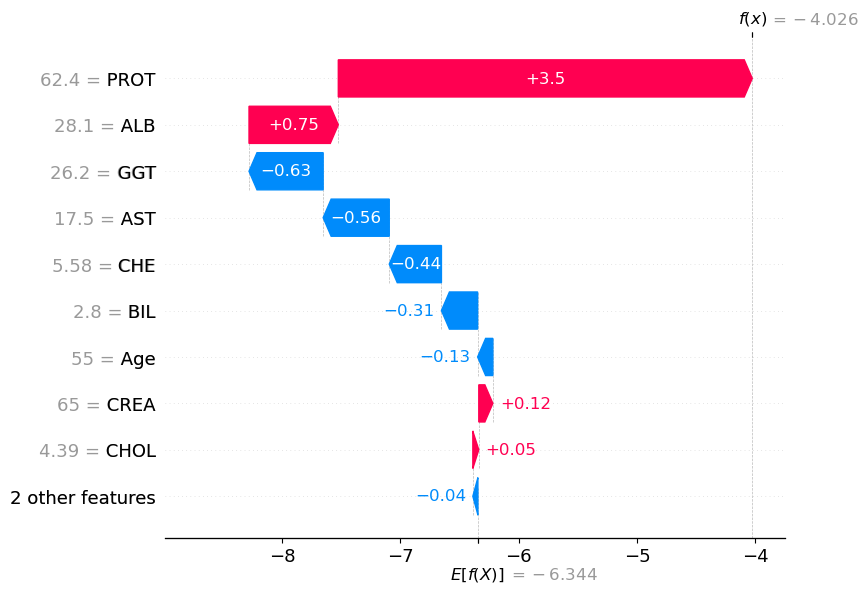

Sample 2 Explanation:


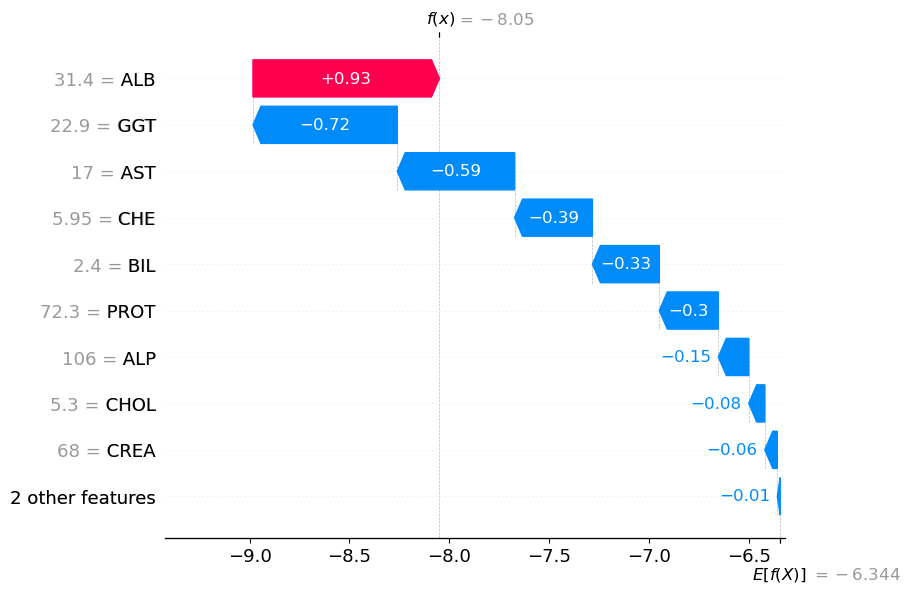

Sample 3 Explanation:


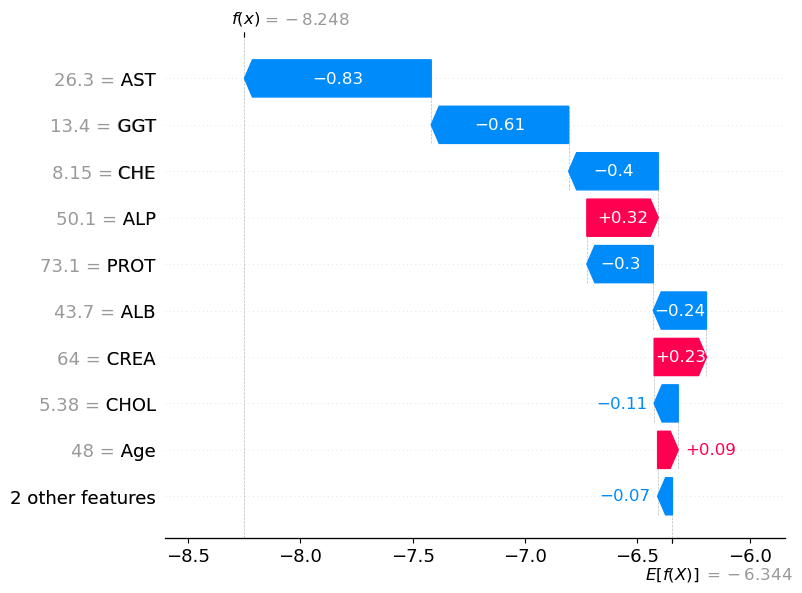

Sample 4 Explanation:


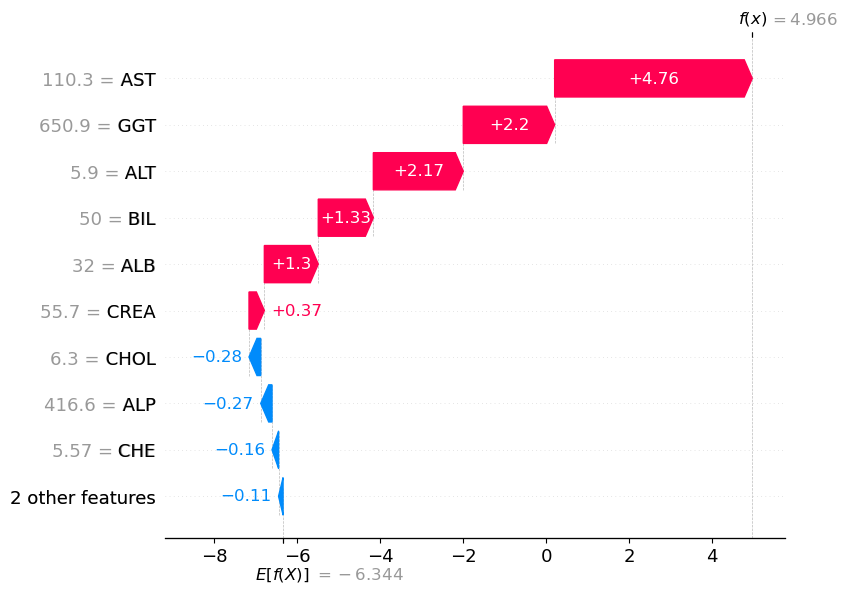

Sample 5 Explanation:


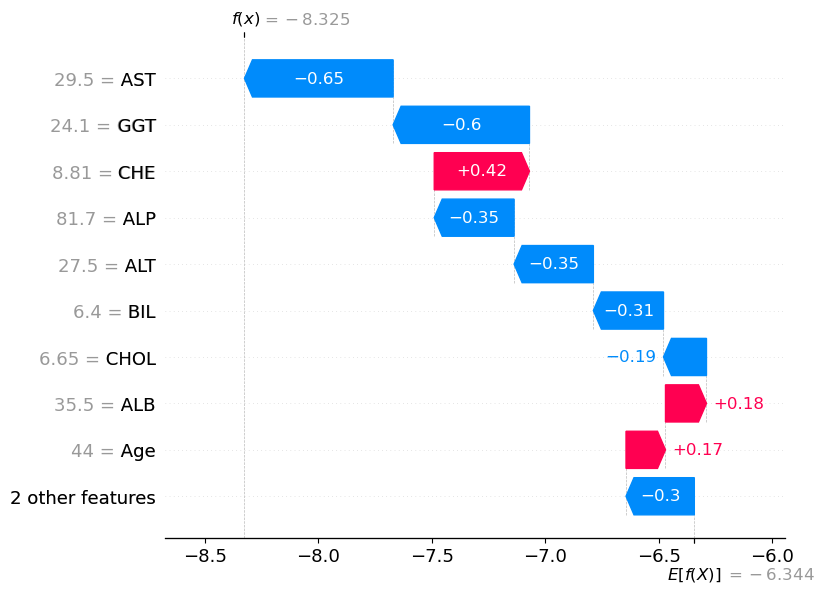

In [82]:
# SHAP for local explanations
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)
print("\nLocal Explanations for 5 Selected Samples:")
for i in range(5):
    print(f"Sample {i+1} Explanation:")
    shap.plots.waterfall(shap_values[i], max_display=10)


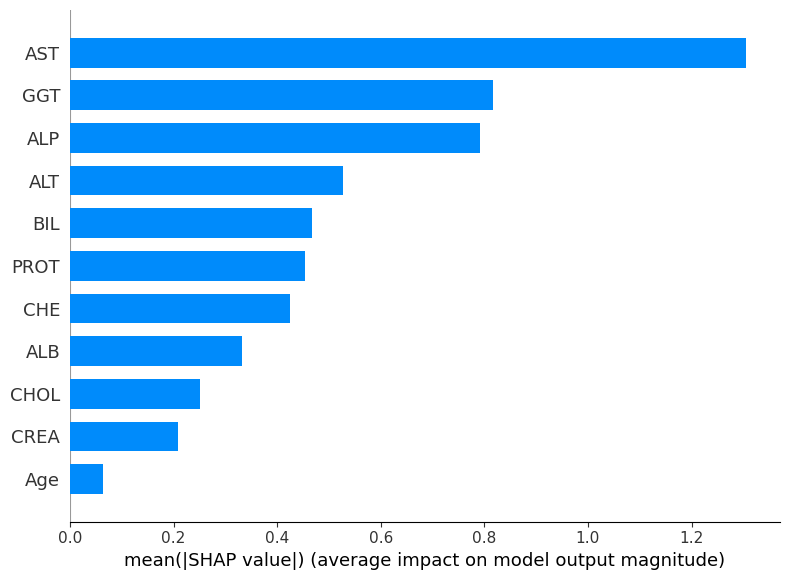

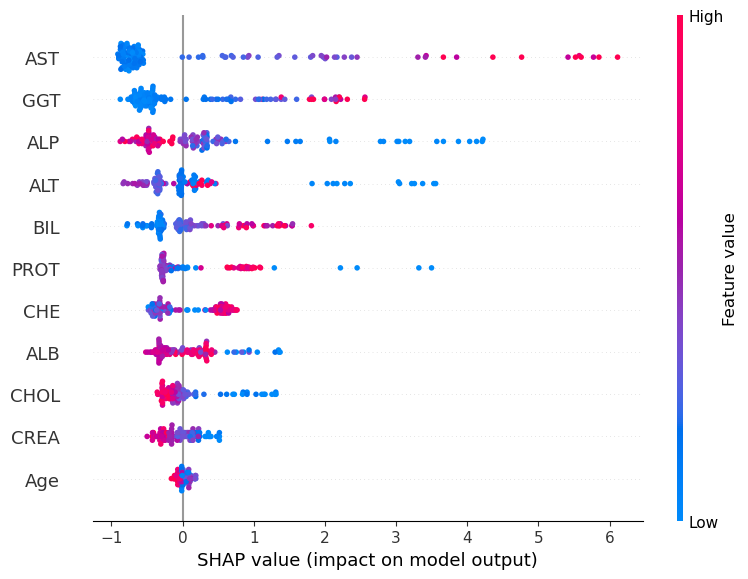

In [83]:
# SHAP for global explanations
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

In [84]:
# Compare XGBoost to Decision Tree
decision_tree_accuracy = 0.85  # Assumed accuracy from Decision Tree step
print(f"Decision Tree Accuracy: {decision_tree_accuracy:.2f}")
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
if accuracy_xgb > decision_tree_accuracy:
    print("XGBoost outperforms Decision Tree in predictive power.")
else:
    print("Decision Tree remains competitive with XGBoost.")

Decision Tree Accuracy: 0.85
XGBoost Accuracy: 0.96
XGBoost outperforms Decision Tree in predictive power.


In [85]:
class CombinedModel:
    def __init__(self, xgb_params=None, dt_params=None, anomaly_params=None):
        # Initialize models with parameters
        xgb_params = xgb_params or {}
        dt_params = dt_params or {}
        anomaly_params = anomaly_params or {}

        # Remove redundant 'max_depth' from dt_params if already set
        if 'max_depth' in dt_params:
            dt_params.pop('max_depth')

        self.xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **xgb_params)
        self.dt_model = DecisionTreeClassifier(max_depth=3, random_state=42, **dt_params)
        self.anomaly_model = IsolationForest(random_state=42, **anomaly_params)

    def fit(self, X, y):
        # Fit the anomaly detection model only on class 0 (valid blood donors)
        X_class_0 = X[y == 0]
        self.anomaly_model.fit(X_class_0)

        # Fit the decision tree and XGBoost models on the full dataset
        self.dt_model.fit(X, y)
        self.xgb_model.fit(X, y)

    def predict(self, X):
        # Anomaly detection predictions
        anomaly_preds = self.anomaly_model.predict(X)
        # Decision tree and XGBoost predictions
        dt_preds = self.dt_model.predict(X)
        xgb_preds = self.xgb_model.predict(X)
        
        # Combine results
        combined_preds = []
        for i in range(len(X)):
            if anomaly_preds[i] == -1:  # Anomaly detected
                combined_preds.append("Anomaly")
            else:
                combined_preds.append({
                    "Decision Tree": dt_preds[i],
                    "XGBoost": xgb_preds[i]
                })
        return combined_preds

    def evaluate(self, X, y):
        # Evaluate both XGBoost and Decision Tree
        dt_preds = self.dt_model.predict(X)
        xgb_preds = self.xgb_model.predict(X)
        dt_accuracy = accuracy_score(y, dt_preds)
        xgb_accuracy = accuracy_score(y, xgb_preds)

        print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
        print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")

        return dt_accuracy, xgb_accuracy

    def explain(self, X):
        # SHAP for XGBoost explanations
        explainer = shap.Explainer(self.xgb_model, X)
        shap_values = explainer(X)

        # Local explanations for 5 samples
        print("\nLocal Explanations for 5 Selected Samples:")
        for i in range(5):
            print(f"Sample {i+1} Explanation:")
            shap.plots.waterfall(shap_values[i], max_display=10)

        # Global explanations
        print("\nGlobal Feature Importance:")
        shap.summary_plot(shap_values, X, plot_type="bar")

In [86]:
# Initialize the combined model
combined_model = CombinedModel(
    xgb_params={'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 100},
    dt_params={'max_depth': 3},
    anomaly_params={'n_estimators': 100}
)

(__init__ method):
Takes parameters for each model (XGBoost, Decision Tree, and Isolation Forest) to customize their behavior.
Initializes each model with default.
Removes unnecessary parameters (like max_depth) from Decision Tree settings to avoid conflicts.

training(fit method):
Anomaly Detection (Isolation Forest) is trained only on samples labeled as class 0 (e.g., valid blood donors in this case).
XGBoost and Decision Tree are trained on the entire dataset to classify all samples.

(predict method):
Runs the Isolation Forest to detect anomalies. If a sample is an anomaly, it labels it as "Anomaly".
For non-anomalous samples, it predicts using both the Decision Tree and XGBoost models, combining their results.

(evaluate method):
Measures and prints the accuracy of the Decision Tree and XGBoost models by comparing their predictions to the actual labels.

(explain method):
Uses the SHAP library to explain how the XGBoost model makes decisions.
Provides:
Local Explanations for 5 specific samples, showing the impact of features on individual predictions.
Global Explanations to display overall feature importance, helping to understand which features the model values most.

In [87]:
# Fit the model
combined_model.fit(X_train, y_train)

C:\Users\khush\Downloads\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [88]:
# Evaluate the model
dt_accuracy, xgb_accuracy = combined_model.evaluate(X_test, y_test)


Decision Tree Accuracy: 0.89
XGBoost Accuracy: 0.93


In [89]:
# Predict and display combined results
combined_preds = combined_model.predict(X_test)
for i, pred in enumerate(combined_preds[:5]):
    print(f"Sample {i+1} Prediction: {pred}")


Sample 1 Prediction: {'Decision Tree': 0, 'XGBoost': 0}
Sample 2 Prediction: {'Decision Tree': 0, 'XGBoost': 0}
Sample 3 Prediction: {'Decision Tree': 0, 'XGBoost': 0}
Sample 4 Prediction: Anomaly
Sample 5 Prediction: {'Decision Tree': 0, 'XGBoost': 0}


Normal Samples:
For most samples, the model provides combined predictions from the Decision Tree and XGBoost models. In this case, they agree that the samples belong to class 0.
Anomalies: 
If a sample is flagged as an anomaly, the Isolation Forest overrides the other predictions and labels it as "Anomaly".
Use Case:
Decision Tree and XGBoost work well for classifying normal samples.
Isolation Forest ensures that unusual data points are identified and flagged appropriately.
This approach helps handle both classification tasks and anomaly detection in a single framework.


Local Explanations for 5 Selected Samples:
Sample 1 Explanation:


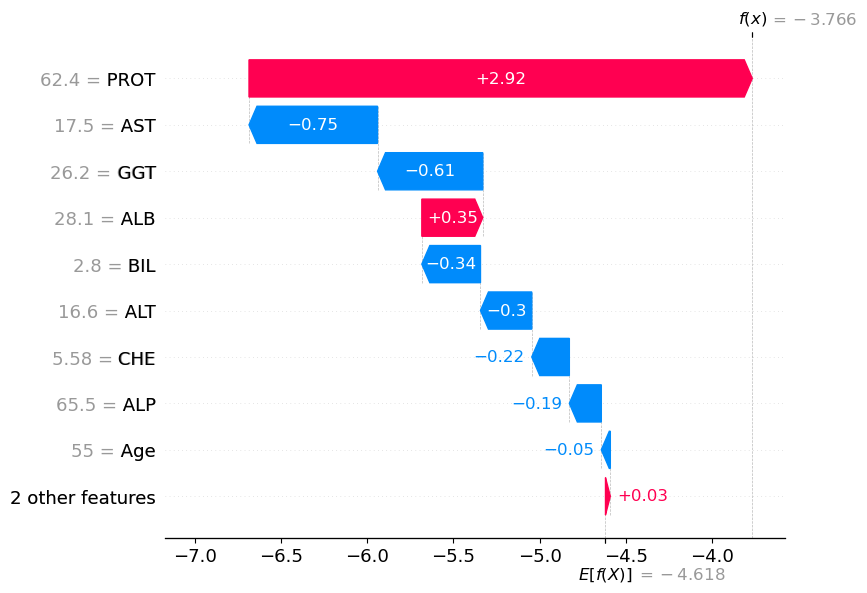

Sample 2 Explanation:


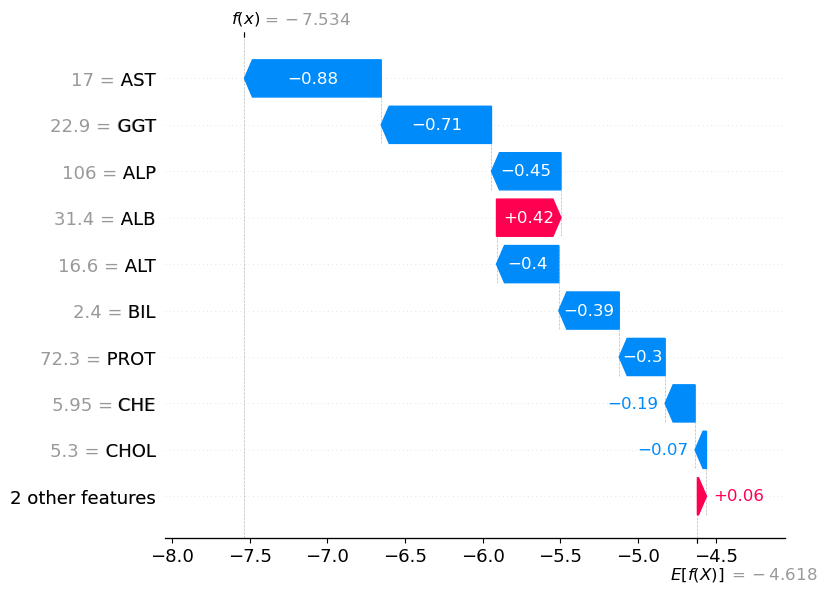

Sample 3 Explanation:


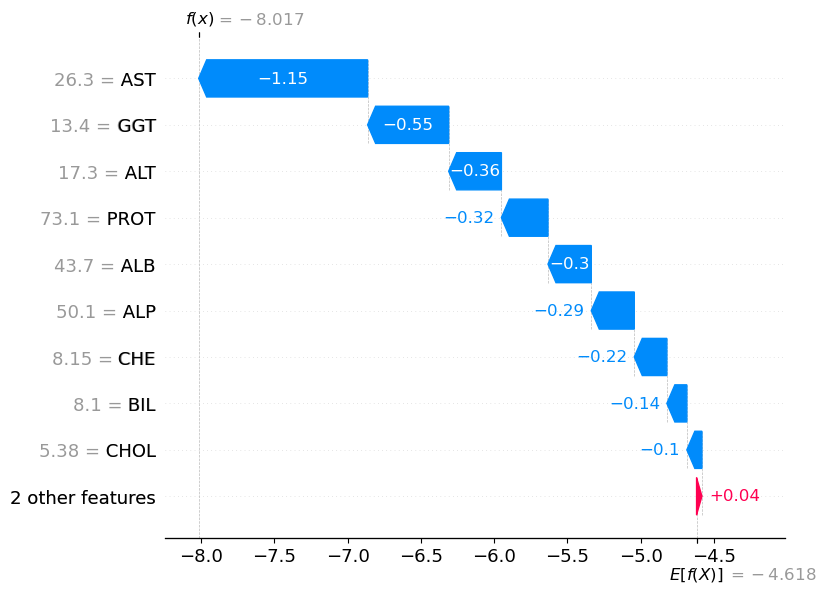

Sample 4 Explanation:


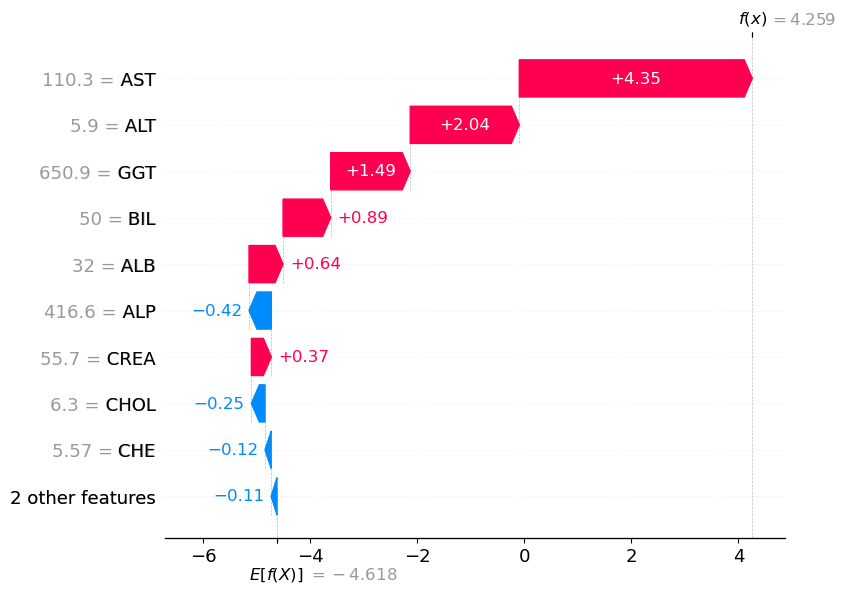

Sample 5 Explanation:


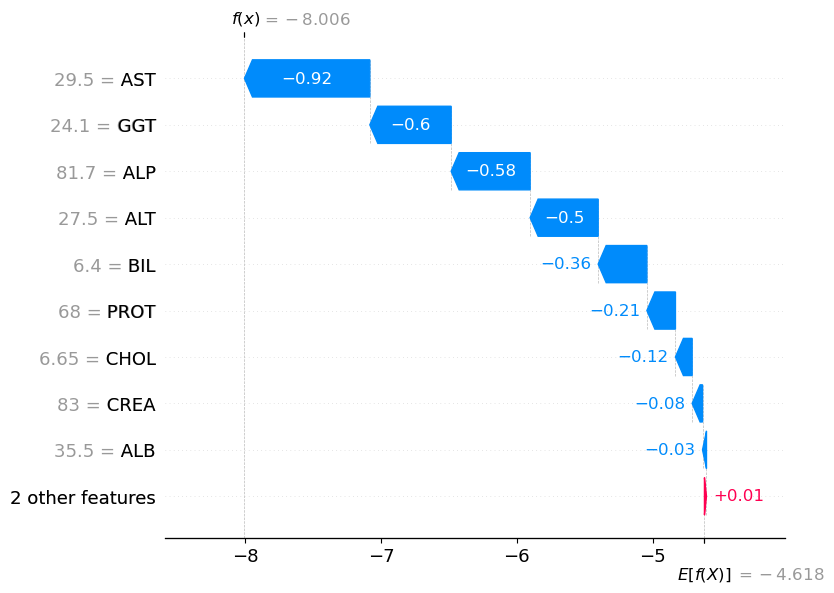


Global Feature Importance:


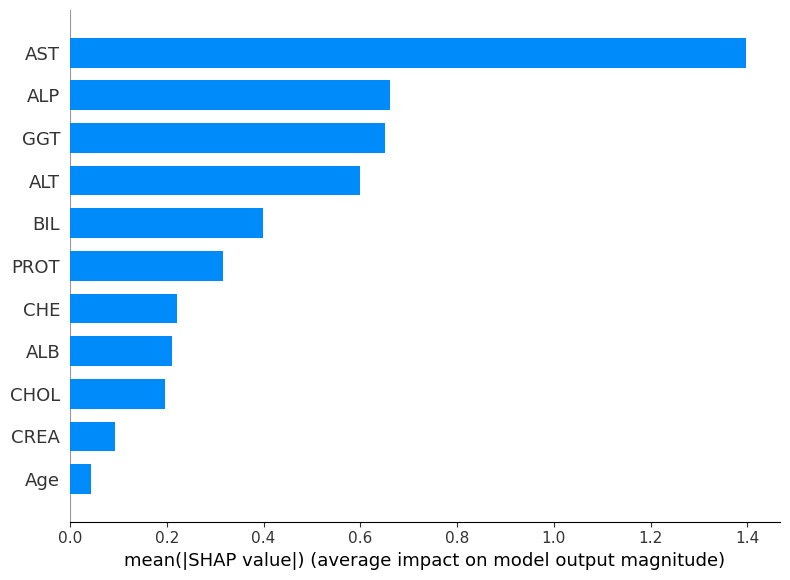

In [90]:
# Explain the predictions
combined_model.explain(X_test)